# Часть 1. SQL

Вводная информация об объекте исследования:
Работа с данными, которые собираются с самосвалов, перевозящих породу на карьере. На самосвалах стоят датчики, которые собирают множество различной информации (скорость, высота, расход топлива и тд). Данные с каждого датчика приходят вместе с временной меткой, идентификатором самосвала и его местоположением (координатами) в момент получения значения с датчика.

Карьер состоит из пунктов погрузки, пунктов разгрузки и маршрутов между ними.

Одним рейсом самосвала называется его движение от пункта погрузки до пункта разгрузки и обратно до пункта погрузки.

Дана упрощенная схема базы данных:

![](https://drive.google.com/uc?export=view&id=1eZVg0OMLNh3Zn4Ss00oNw6KtcMYMTtdZ)

**telemetry** - таблица с телеметрией карьерных самосвалов следующего формата:

| id | objectid | time | sensorid | value | lat | lon | speed|
| :-: |:-: |:-: |:-: |:-: |:-: |:-: |:-: |
| 42 | 123 | 01.01.2024 | 21:00:54 | 35 | 85,694 | 51.384 | 41.857 | 15.81 |

где
* id - номер записи в таблице
* objectid - идентификатор самосвала
* time - момент времени
* sensorid - идентификатор датчика
* value - значение, которое передал датчик
* lat, lon - координаты
* speed - текущая скорость самосвала

**objects** - таблица, в которой хранится информация о самосвалах:

| id | modelname | enterprise_id | created_at |
| :-: |:-: |:-: |:-: |
| 123 | БелАЗ-75131 | 4 | 01.01.2024 | 00:00:00 |

где
* id - идентификатор самосвала
* modelname - модель самосвала
* enterprise_id - идентификатор предприятия
* created_at - временная метка создания записи

**sensors** - таблица с описанием датчиков:

| id | name | tag | min_value | max_value |
| :-: |:-: |:-: |:-: | :-: |
| 35 | Вес | weight | 0 | 180 |

где
* id - идентификатор датчика
* name - наименование датчика
* tag - тег датчика
* min_value - минимальное допустимое значение датчика
* max_value - максимальное допустимое значение датчика


## Задание 1
Необходимо написать запрос, который для каждого самосвала модели “БелАЗ-75320” на предприятии с id = 6 выведет процент количества записей телеметрии, когда значение тега высоты (height) находилось в допустимых пределах, относительно всех записей по данному датчику за последние сутки.

valid_records: список значений, находящихся в допустимых пределах, за последние сутки;

total_records: список всех значений за последние сутки;

In [ ]:
WITH valid_records AS (
    SELECT t.objectid
    FROM telemetry t
    JOIN objects o ON t.objectid = o.id
    JOIN sensors s ON t.sensorid = s.id
    WHERE o.modelname = 'БелАЗ-75320'
    AND o.enterprise_id = 6
    AND s.tag = 'height'
    AND t.value BETWEEN s.min_value AND s.max_value
    AND t.time > NOW() - INTERVAL '1 day'
),
total_records AS (
    SELECT t.objectid
    FROM telemetry t
    JOIN objects o ON t.objectid = o.id
    JOIN sensors s ON t.sensorid = s.id
    WHERE o.modelname = 'БелАЗ-75320'
    AND o.enterprise_id = 6
    AND s.tag = 'height'
    AND t.time > NOW() - INTERVAL '1 day'
)
SELECT v.objectid, COUNT(v.objectid) * 100.0 / NULLIF(COUNT(t.objectid), 0) AS percentage
FROM valid_records v
FULL JOIN total_records t ON v.objectid = t.objectid
GROUP BY v.objectid;

## Задание 2
Необходимо написать запрос, для вывода уникальных значений по датчику satenum (количество доступных спутников связи) для каждого самосвала с идентификатором из списка [34, 42, 99] за последние двое суток.

In [ ]:
SELECT t.objectid, DISTINCT t.value
FROM telemetry t
JOIN sensors s ON t.sensorid = s.id
WHERE s.tag = 'satenum'
AND t.objectid IN (34, 42, 99)
AND t.time > NOW() - INTERVAL '2 day';

## Задание 3
В таблицу с телеметрией собираются данные с датчика уровня топлива в процентах (тег fuel_tank_level). В данной задаче будем считать, что самосвалы в течение последнего часа ездят непрерывно, а значит и уровень топлива постепенно снижается. Необходимо написать запрос, который для каждого самосвала модели “БелАЗ-75131” вернет 1, если был зафиксирован хоть один случай, когда между двумя последовательными временными точками изменение уровня топлива было более 5%, или вывести 0, если подобной аномалии не было.

In [ ]:
WITH fuel_data AS (
    SELECT
        t.objectid,
        t.time,
        t.value,
        LAG(t.value) OVER (PARTITION BY t.objectid ORDER BY t.time) as prev_value
    FROM telemetry t
    JOIN objects o ON t.objectid = o.id
    JOIN sensors s ON t.sensorid = s.id
    WHERE o.modelname = 'БелАЗ-75131'
    AND s.tag = 'fuel_tank_level'
    AND t.time > NOW() - INTERVAL '1 hour'
)
SELECT
    objectid,
    CASE
        WHEN ABS((value - prev_value) / prev_value * 100) > 5 THEN 1
        ELSE 0
    END AS anomaly
FROM fuel_data
GROUP BY objectid;

# Часть 2. Python

## Данные:

**telemetry.parquet** - данные телеметрии
* objectid - идентификатор самосвала
* tripid - идентификатор рейса
* driverid - идентификатор водителя
* time - время получения данных с датчиков
* lat, lon - широта и долгота самосвала в текущий момент времени
* x, y, - координаты самосвала на плоскости (https://en.wikipedia.org/wiki/Universal_Transverse_Mercator_coordinate_system)
* speed - данные с датчика скорости
* height - высота в текущий момент времени
* engine_speed - обороты двигателя
* fuel_cons - мгновенный расход топлива
* fuel_tank_level - уровень топлива в баке (в процентах)
* weight_dynamic - мгновенное значение веса с датчика (растет, пока самосвал грузит, колеблется вокруг константы, когда едет загруженный и обнуляется при разгрузке и движении без груза обратно на погрузку)
* weight - значение веса груза, который перевез самосвал за текущий рейс (константа для каждого рейса. Даже на той части рейса, где самосвал ехал пустым обратно на погрузку значение этого параметра будет равно весу груза)
* DQ_vertical_bump - вертикальное ускорения
* accelerator_position - позиция педали газа
* w_fl - ?

Пропуски в колонках fuel_tank_level и weight_dynamic обусловлены тем, что эти датчики собираются с меньшей дискретностью (условно, раз в 10 секунд, а не раз в секунду). При необходимости, можно восполнить Nan значения последним определенным значением (т.е. [1, 2, nan, 3, nan, 4, ...] -> [1, 2, 2, 3, 3, 4, ...])

**weather_hourly.parquet** - почасовая погода на карьере. Значения колонок понятны из их названий.

## Задание 1

* Отобразить на графике все местоположения самосвалов из исходных данных (предварительно убрав очевидные выбросы по координатам) = карта карьера (пока некорректная из-за ещё некоторых проблем с координатами)
* Обнаружить самосвал(ы), для которых всё ещё есть проблемы с координатами (обозначить их идентификаторы)
* Понять, по какому параметру можно избавиться от этих выбросов по координатам, и сделать чистку
* Нарисовать корректную карту карьера (если удалость определить, как сделать чистку)
* При необходимости, произвести чистку по другим колонкам (препроцессинг для дальнейшего обучения модели)
* Предположить, что обозначают значения колонки w_fl (путем анализа имеющихся данных) - ответ написать в текстовом поле и обосновать

In [ ]:
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt

Работаю в colab, поэтому загрузил файлы на свой диск. Подключаю диск для дальнейшей работы с данными.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
tel = pd.read_parquet('/content/drive/MyDrive/telemetry.parquet')
wth = pd.read_parquet('/content/drive/MyDrive/weather_hourly.parquet')

Строим по первоначальным данным карту передвижения самосвалов.

Видим очевидный выброс в (0;0)

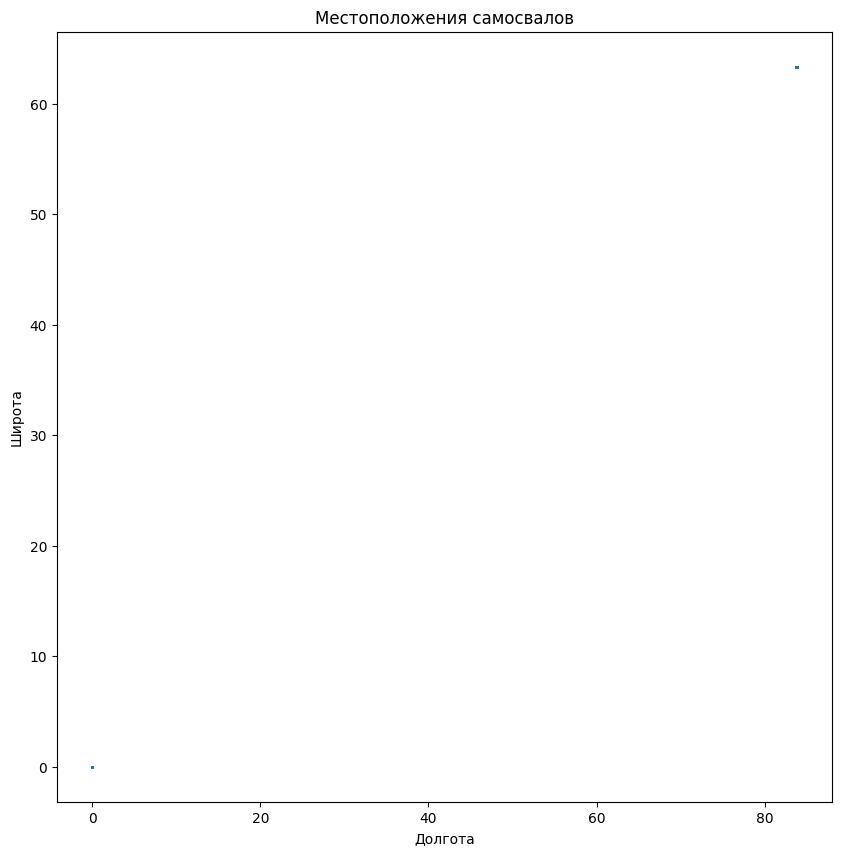

In [ ]:
# Строю карту для местоположений самосвалов
plt.figure(figsize=(10, 10))
plt.scatter(tel['lon'], tel['lat'], s=1)
plt.title('Местоположения самосвалов')
plt.xlabel('Долгота')
plt.ylabel('Широта')
plt.show()

Снова строим карту, предварительно выбрав данные без очевидных выбросов

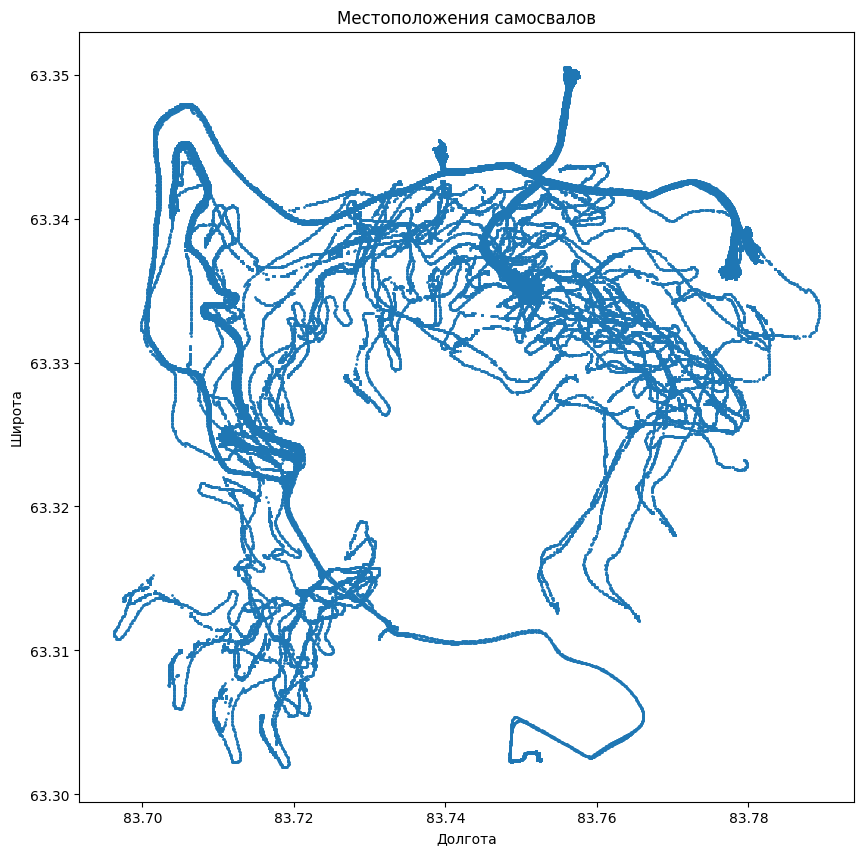

In [ ]:
# Удаление выбросов по координатам

tel = tel[(tel['lat'] != 0) & (tel['lon'] != 0)]

plt.figure(figsize=(10, 10))
plt.scatter(tel['lon'], tel['lat'], s=1)
plt.title('Местоположения самосвалов')
plt.xlabel('Долгота')
plt.ylabel('Широта')
plt.show()

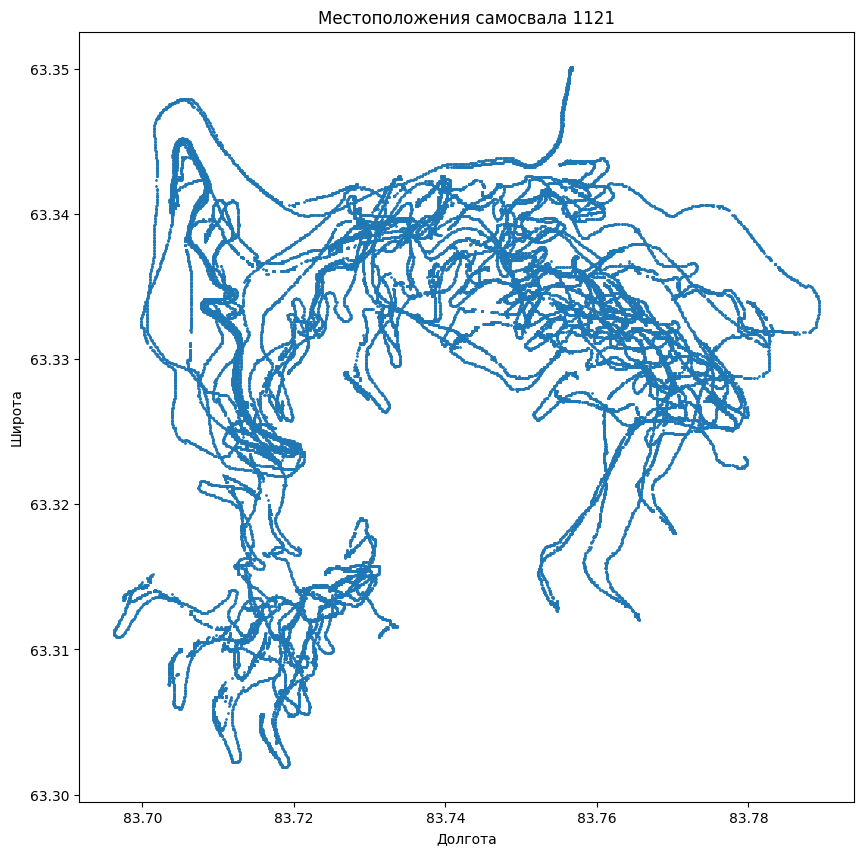

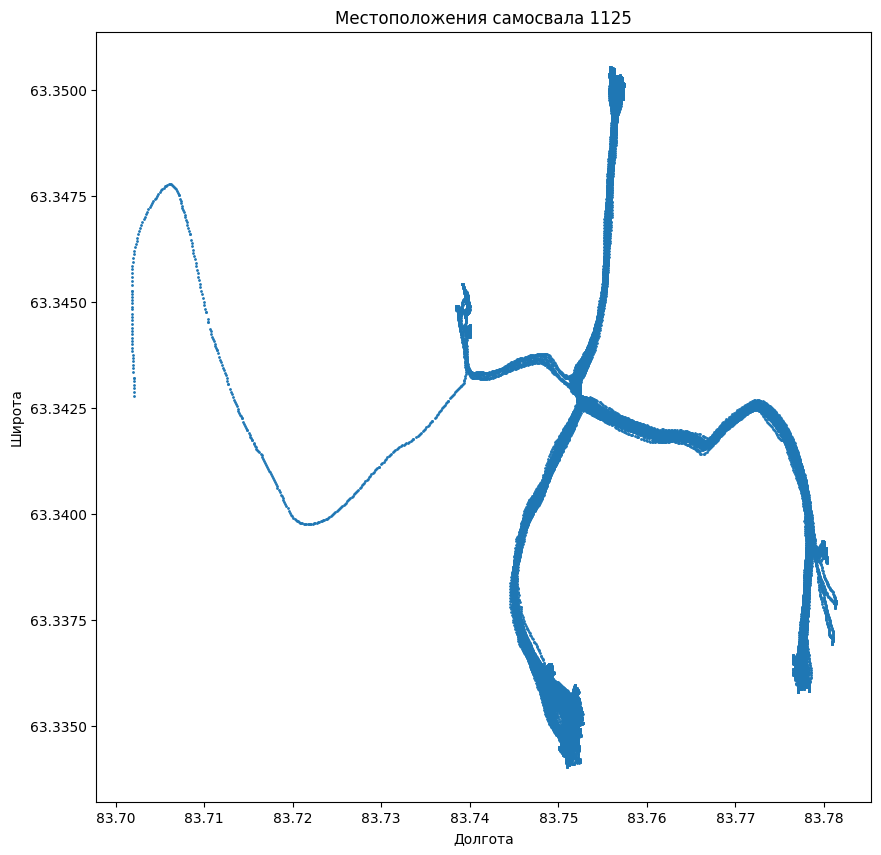

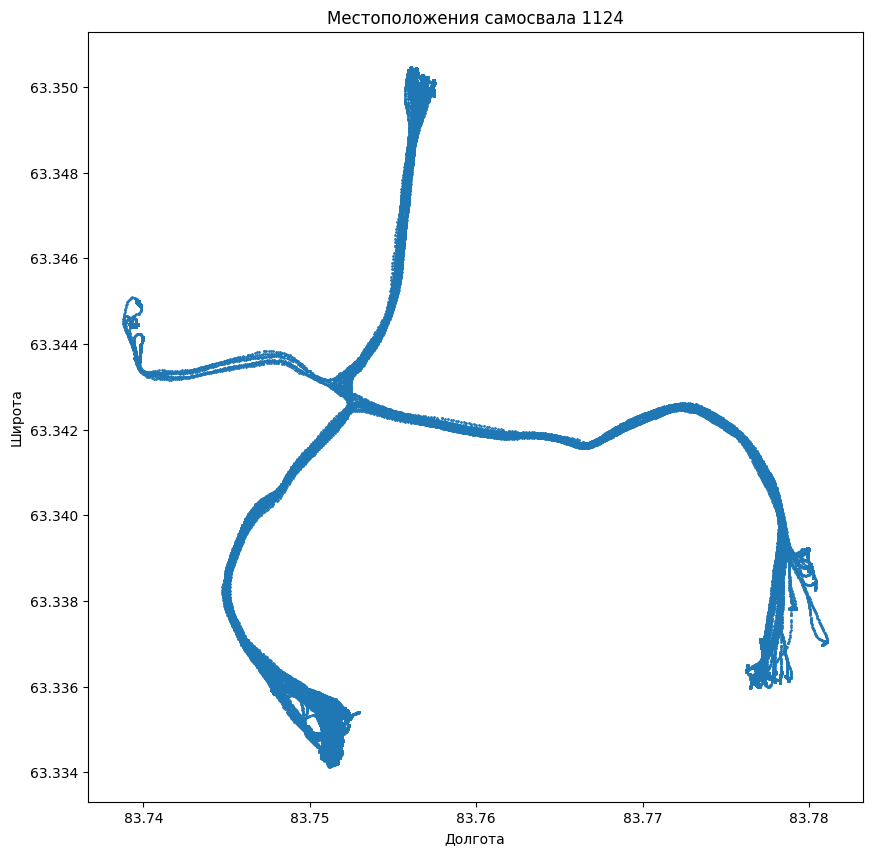

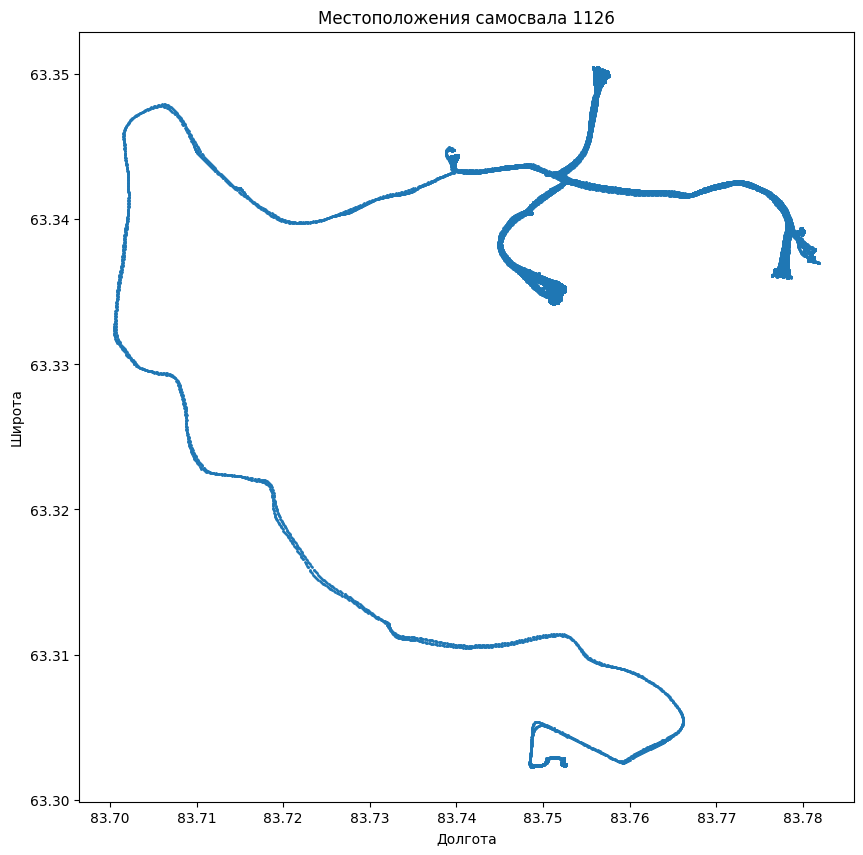

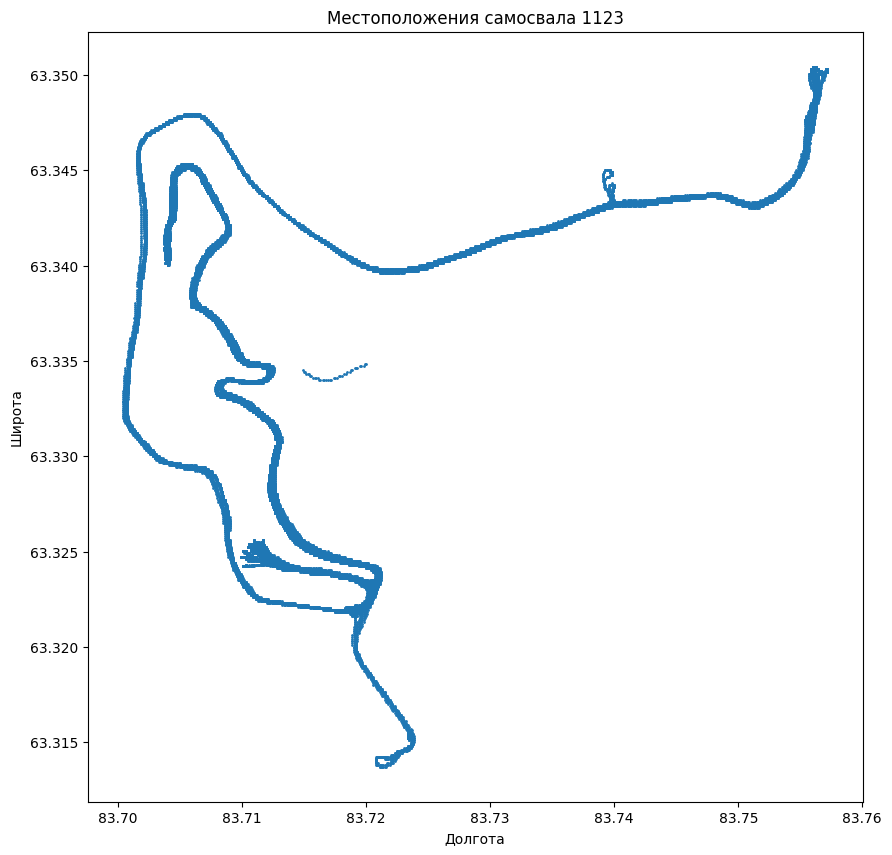

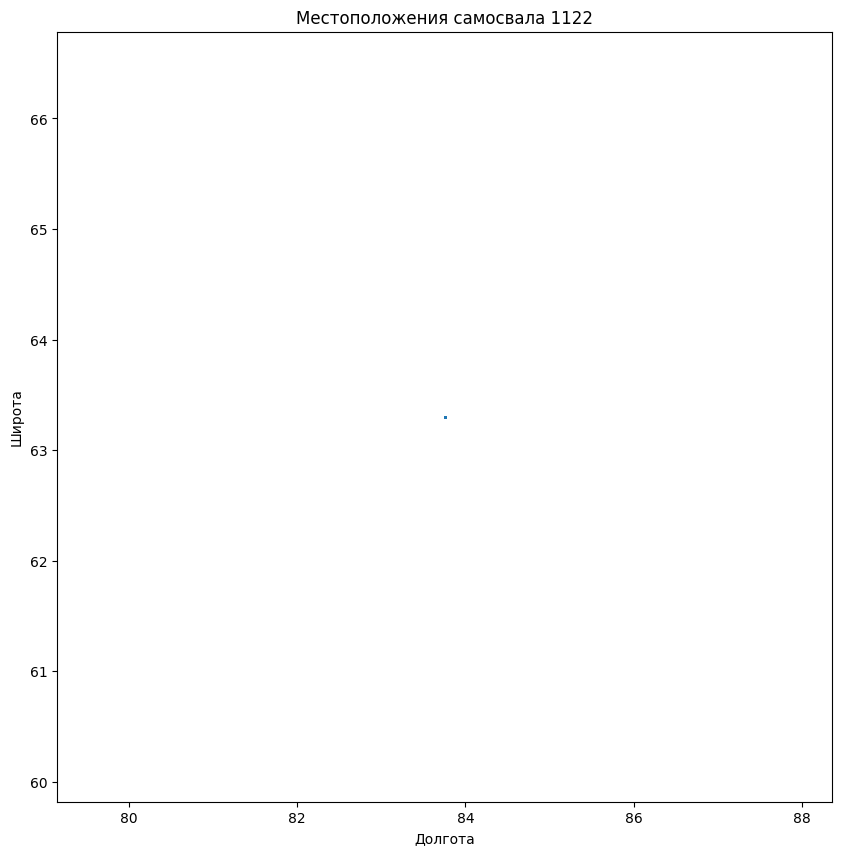

In [ ]:
# Строю карту местоположения каждого самосвала, чтобы посмотреть на проблемы
# с координатами у каждого отдельного objectid

objectids = tel['objectid'].unique()

for obj in objectids:
    df_obj = tel[(tel['objectid'] == obj)]
    plt.figure(figsize=(10, 10))
    plt.scatter(df_obj['lon'], df_obj['lat'], s=1)
    plt.title(f'Местоположения самосвала {obj}')
    plt.xlabel('Долгота')
    plt.ylabel('Широта')
    plt.show()

Проблемы с самосвалами:

1121:

Множество непонятных линий, похожих на основной маршрут(более жирные линии), которые делают карту нечитаемой.

1122:

Видим, что самосвал с objectid = 1122 не двигался с места. Возможно не работал корректно GPS или самосвал действительно не двигался.

1123:

Линия, оторванная от основного маршрута

1125:

Есть единичная линия, которая, если посмотреть на все карты движения самосвалов, начинает маршрут, как у самосвала с индексом 1126, но обрывается.


In [ ]:
tel[tel['objectid'] == 1121].head(10)

,objectid,time,lat,lon,speed,height,fuel_cons,engine_speed,hdop,DQ_vertical_bump,accelerator_position,fuel_tank_level,weight_dynamic,tripid,weight,driverid,w_fl,x,y
0,1121,2023-11-08 05:31:31.309000+07:00,63.328824,83.727988,3.003940,195.7,390.0,NaN,99.99,0,0,60.0,216.0,1003671.0,215.0,2891.0,1,636592.202274,7.025133e+06
4,1121,2023-11-08 11:09:49.347000+07:00,63.331924,83.765388,0.000000,70.9,17.0,NaN,99.99,0,0,38.0,0.0,1003728.0,204.0,2894.0,0,638449.084136,7.025559e+06
5,1121,2023-11-08 11:07:48.346000+07:00,63.331924,83.765388,0.009260,70.5,2.0,NaN,99.99,0,0,38.0,0.0,1003728.0,204.0,2894.0,0,638449.084136,7.025559e+06
12,1121,2023-11-08 01:31:43.811000+07:00,63.340124,83.710388,19.594200,196.8,229.0,NaN,99.99,0,0,33.0,1.0,1003647.0,212.0,2891.0,0,635658.122195,7.026354e+06
16,1121,2023-11-08 01:23:52.841000+07:00,63.342624,83.739688,0.114824,268.7,10.0,NaN,99.99,0,0,33.0,0.0,1003647.0,212.0,2891.0,0,637112.052868,7.026695e+06
17,1121,2023-11-08 16:14:54.328000+07:00,63.333624,83.754688,1.742730,170.9,396.0,NaN,99.99,0,0,62.0,201.0,1003760.0,202.0,2894.0,1,637905.497090,7.025725e+06
25,1121,2023-11-08 16:09:47.381000+07:00,63.331524,83.762688,19.218200,117.1,82.0,NaN,99.99,0,0,66.0,199.0,1003760.0,202.0,2894.0,1,638315.891879,7.025508e+06
30,1121,2023-11-08 04:49:08.317000+07:00,63.328224,83.716488,3.033580,219.2,81.0,NaN,99.99,0,0,63.0,0.0,1003671.0,215.0,2891.0,0,636019.480326,7.025042e+06
31,1121,2023-11-08 19:46:48.883000+07:00,63.325524,83.712988,0.000000,-1.0,28.0,NaN,99.99,0,0,50.0,0.0,1003799.0,218.0,2894.0,0,635857.037286,7.024734e+06
44,1121,2023-11-08 09:27:08.381000+07:00,63.340524,83.742988,3.146550,127.9,400.0,NaN,99.99,0,0,45.0,216.0,1003707.0,218.0,2894.0,1,637287.143210,7.026468e+06


Проблемы с самосвалом 1121 и 1122 решил отбросом строк, где значение HDOP (Horizontal Dilution of Precision) меньше или равно 15, данное значение обеспечивает умеренную точность определения координат. Большие значения дают очень плохую точность.

Проблемы с самосвалами 1123 и 1125 решил выборкой тех данных, в которых нет "неправильных" линий.


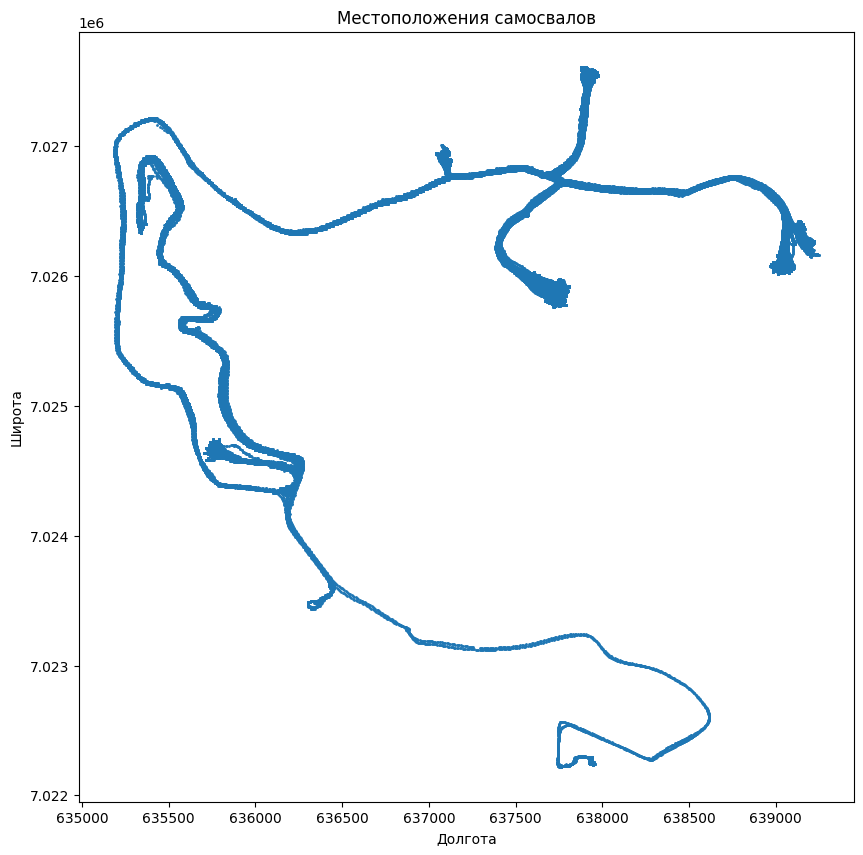

In [ ]:
# Первое условие(first_cond) отсеивает неверные коорд. для самосвала с id 1123,
# а второе(second_cond) - для самосвала с 1125

first_cond = (
    (tel['objectid'] == 1123) &
    (tel['lat'].between(63.33, 63.335)) &
    (tel['lon'].between(83.714, 83.72))
)
second_cond = (
    (tel['objectid'] == 1125) &
    (tel['lat'].between(63.3375, 63.3435)) &
    (tel['lon'].between(83.7, 83.7395)) |
    (tel['objectid'] == 1125) &
    (tel['lat'].between(63.3425, 63.35)) &
    (tel['lon'].between(83.7, 83.72))
)
# Строю новую карту местоположения самосвалов
tel = tel[(tel['hdop'] <= 15) & ~first_cond & ~second_cond]
df_obj = tel
plt.figure(figsize=(10, 10))
plt.scatter(df_obj['x'], df_obj['y'], s=1)
plt.title('Местоположения самосвалов')
plt.xlabel('Долгота')
plt.ylabel('Широта')
plt.show()

In [ ]:
# Проверяю данные для дальнейщей чистки

tel.isna().sum()

objectid                     0
time                         0
lat                          0
lon                          0
speed                        0
height                       0
fuel_cons                    0
engine_speed             85974
hdop                         0
DQ_vertical_bump             0
accelerator_position         0
fuel_tank_level         255471
weight_dynamic          255471
tripid                     603
weight                     603
driverid                   603
w_fl                         0
x                            0
y                            0
dtype: int64

In [ ]:
# Смотрю, что в данных строках

tel[tel['weight'].isnull()]

,objectid,time,lat,lon,speed,height,fuel_cons,engine_speed,hdop,DQ_vertical_bump,accelerator_position,fuel_tank_level,weight_dynamic,tripid,weight,driverid,w_fl,x,y
1372,1125,2023-11-08 23:51:33+07:00,63.337907,83.781191,0.7,278.0,2.35,1050.750,7.0,0,0,NaN,NaN,NaN,NaN,NaN,0,639210.970658,7.026259e+06
1634,1125,2023-11-08 23:51:42+07:00,63.337914,83.781178,0.1,278.0,30.40,801.375,7.0,0,0,NaN,NaN,NaN,NaN,NaN,0,639210.286419,7.026260e+06
2041,1125,2023-11-08 23:52:23+07:00,63.338412,83.779771,17.5,275.0,257.00,1474.000,8.0,0,0,NaN,NaN,NaN,NaN,NaN,0,639137.486827,7.026312e+06
2062,1125,2023-11-08 23:54:40+07:00,63.341622,83.765794,39.2,278.0,159.00,1173.125,7.0,0,0,NaN,NaN,NaN,NaN,NaN,0,638422.782469,7.026639e+06
3591,1125,2023-11-08 23:59:22+07:00,63.334887,83.751739,0.1,270.0,2.85,826.250,11.0,0,0,NaN,NaN,NaN,NaN,NaN,0,637751.891481,7.025859e+06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
420880,1124,2023-11-08 23:59:01+07:00,63.336219,83.776708,8.7,270.0,72.20,1078.875,8.0,0,0,NaN,NaN,NaN,NaN,NaN,0,638994.827960,7.026061e+06
422407,1125,2023-11-08 23:55:43+07:00,63.342304,83.755583,36.6,274.0,117.35,1226.125,9.0,0,0,NaN,NaN,NaN,NaN,NaN,0,637908.710619,7.026693e+06
424025,1125,2023-11-08 23:51:46+07:00,63.337915,83.781179,0.7,278.0,3.45,743.500,7.0,0,0,NaN,NaN,NaN,NaN,NaN,0,639210.331616,7.026260e+06
424819,1124,2023-11-08 23:59:44+07:00,63.337857,83.778211,22.0,271.0,108.70,1317.875,6.0,0,0,NaN,NaN,NaN,NaN,NaN,0,639062.119739,7.026247e+06


По всей видимости, строки, где tripid, weight, driverid это None значения - одни и те же строки.

In [ ]:
# Перед удалением строк заполню пропуски в
# колонках fuel_tank_level и weight_dynamic

tel.sort_values(by=['objectid', 'time'], inplace=True)
tel['fuel_tank_level'].fillna(method='ffill', inplace=True)
tel['weight_dynamic'].fillna(method='ffill', inplace=True)

In [ ]:
# Удаляю данные строки, т.к. их количество(955) пренебрежимо мало для нас

tel = tel.dropna(subset=['weight'])

In [ ]:
tel.isna().sum()

objectid                    0
time                        0
lat                         0
lon                         0
speed                       0
height                      0
fuel_cons                   0
engine_speed            85974
hdop                        0
DQ_vertical_bump            0
accelerator_position        0
fuel_tank_level             0
weight_dynamic              0
tripid                      0
weight                      0
driverid                    0
w_fl                        0
x                           0
y                           0
dtype: int64

Да, это были одни и те же строки

In [ ]:
# Оцениваю данные на предмет закономерности значений w_fl

tel.head(60)

,objectid,time,lat,lon,speed,height,fuel_cons,engine_speed,hdop,DQ_vertical_bump,accelerator_position,fuel_tank_level,weight_dynamic,tripid,weight,driverid,w_fl,x,y
420794,1121,2023-11-08 00:00:00.803000+07:00,63.346624,83.702188,19.4590,132.0,390.0,NaN,4.91,0,0,41.0,209.0,1003626.0,210.0,2891.0,1,635217.355791,7.027060e+06
235518,1121,2023-11-08 00:00:01.805000+07:00,63.346724,83.702188,19.9201,132.2,383.0,NaN,4.92,0,0,41.0,209.0,1003626.0,210.0,2891.0,1,635216.886103,7.027072e+06
261904,1121,2023-11-08 00:00:02.806000+07:00,63.346824,83.702288,21.2628,132.5,385.0,NaN,4.84,0,0,42.0,209.0,1003626.0,210.0,2891.0,1,635221.418157,7.027083e+06
113820,1121,2023-11-08 00:00:03.807000+07:00,63.346824,83.702388,21.6202,132.8,389.0,NaN,4.83,0,0,42.0,209.0,1003626.0,210.0,2891.0,1,635226.419899,7.027083e+06
156638,1121,2023-11-08 00:00:04.808000+07:00,63.346924,83.702388,21.3536,133.0,389.0,NaN,8.56,0,0,41.0,209.0,1003626.0,210.0,2891.0,1,635225.950176,7.027094e+06
166220,1121,2023-11-08 00:00:06.809000+07:00,63.347024,83.702588,21.4869,133.6,393.0,NaN,3.10,0,0,42.0,209.0,1003626.0,210.0,2891.0,1,635235.483866,7.027106e+06
224363,1121,2023-11-08 00:00:07.810000+07:00,63.347124,83.702688,22.5592,134.0,392.0,NaN,2.09,0,0,41.0,209.0,1003626.0,210.0,2891.0,1,635240.015796,7.027117e+06
43349,1121,2023-11-08 00:01:07.870000+07:00,63.347424,83.706588,20.7257,143.7,44.0,NaN,3.02,0,0,42.0,209.0,1003626.0,210.0,2891.0,1,635433.670124,7.027159e+06
110199,1121,2023-11-08 00:01:09.872000+07:00,63.347324,83.706888,22.4999,143.2,25.0,NaN,4.33,0,0,42.0,209.0,1003626.0,210.0,2891.0,1,635449.145514,7.027148e+06
70926,1121,2023-11-08 00:01:10.873000+07:00,63.347224,83.707188,26.3725,142.6,25.0,NaN,1.56,0,0,43.0,209.0,1003626.0,210.0,2891.0,1,635464.621005,7.027138e+06


Судя по данным появилось ощущение, что значение w_fl зависит от того, нуждается ли самосвал в дозаправке. Но после проверок оказалось, что нет.
Решил проверить, может w_fl = 1 связано с изменением веса.

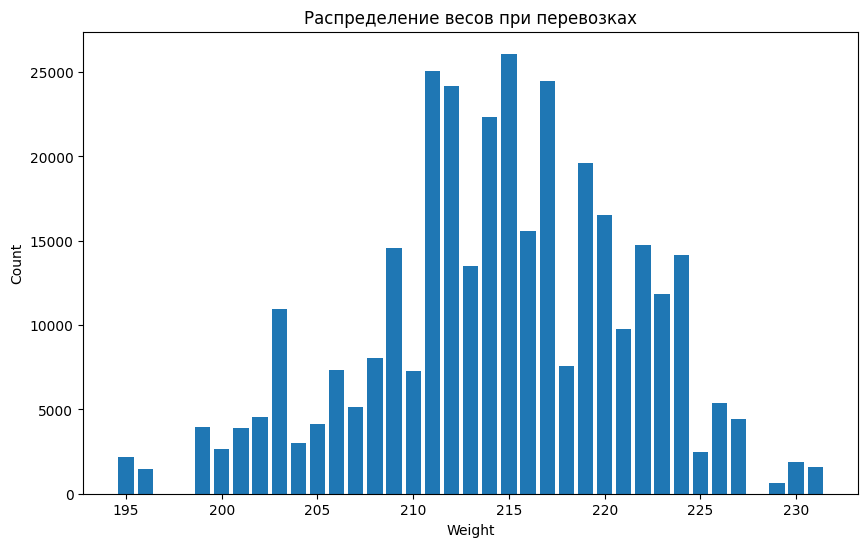

In [ ]:
weights = tel['weight'].value_counts()

# Создание barplot
plt.figure(figsize=(10, 6))
plt.bar(weights.index, weights.values)

plt.xlabel('Weight')
plt.ylabel('Count')
plt.title('Распределение весов при перевозках')

plt.show()

In [ ]:
loading_unloading = tel[(tel['weight_dynamic'].between(200, 231))]
print(loading_unloading['w_fl'].sum(), loading_unloading['w_fl'].count())

35581 36208


In [ ]:
loading_unloading_1 = tel[tel['weight_dynamic'].between(5, 198)]
print(loading_unloading_1['w_fl'].sum(), loading_unloading_1['w_fl'].count())

4036 4123


In [ ]:
loading_unloading_2 = tel[abs(tel['weight_dynamic'] - tel['weight']).between(180, 230)]
print(loading_unloading_2['w_fl'].sum(), loading_unloading_2['w_fl'].count())

1805 45349


## Задание 2

Все пункты делаются на данных, оставшихся после чистки в Задании 1. Правильных ответов (по числам) нет, т к препроцессинг может отличаться. Нам интересно увидеть, как Вы это делаете.
* Вывести средние значения параметров ['hdop', 'speed', 'engine_speed', 'DQ_vertical_bump', 'height'] по самосвалам
* Построить гистограмму суммарных расстояний за каждый рейс.
* Вывести таблицу средних скоростей самосвалов за каждый час суток (формат: колонки - час суток, строки - самосвалы, в ячейках - средняя скорость)
* Выбрать по одному рейсу для каждого самосвала. Для каждого рейса: нарисовать его на общей карте карьера, нарисовать на одном графике кривую изменения скорости от времени и высоты от времени (шкалы должны быть на разных осях).
* Присоединить данные погоды к данным телеметрии

In [ ]:
# Вывожу средние значения параметров по самосвалам

mean_values = tel.groupby('objectid')['hdop', 'speed', 'engine_speed', 'DQ_vertical_bump', 'height'].mean()

# Округление до двух знаков после запятой

mean_values = mean_values.round(2)
mean_values

<ipython-input-19-eb51d0e5465b>:3: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  mean_values = tel.groupby('objectid')['hdop', 'speed', 'engine_speed', 'DQ_vertical_bump', 'height'].mean()


,hdop,speed,engine_speed,DQ_vertical_bump,height
objectid,,,,,
1121,1.86,16.30,NaN,0.0,64.99
1123,1.48,16.33,NaN,0.0,90.89
1124,7.01,12.81,1136.06,0.0,266.97
1125,8.07,13.68,1002.53,0.0,265.23
1126,7.52,13.43,1161.52,0.0,262.82


In [ ]:
from geopy.distance import geodesic

<ipython-input-32-814515410bcb>:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({'distance': distance, 'num_trips': num_trips}, ignore_index=True)
<ipython-input-32-814515410bcb>:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({'distance': distance, 'num_trips': num_trips}, ignore_index=True)
<ipython-input-32-814515410bcb>:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({'distance': distance, 'num_trips': num_trips}, ignore_index=True)
<ipython-input-32-814515410bcb>:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append

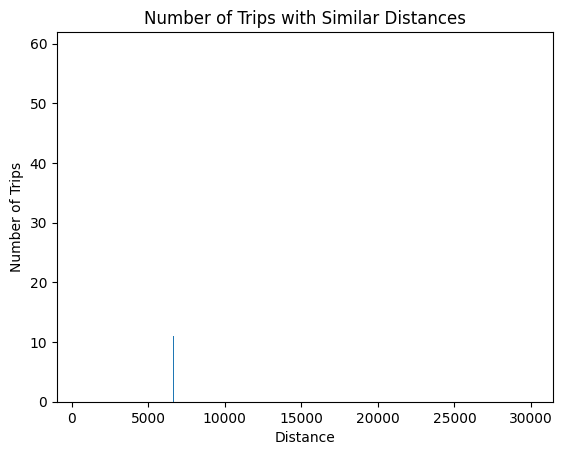

In [ ]:
# Сортировка данных по tripid и времени
df = tel.sort_values(['tripid', 'time'])

# Создание новых столбцов с предыдущими значениями широты и долготы
df['prev_lat'] = df.groupby('tripid')['lat'].shift()
df['prev_lon'] = df.groupby('tripid')['lon'].shift()

# Расчет расстояния между текущей и предыдущей точкой для каждого рейса
df['distance'] = df.apply(lambda row: geodesic((row['lat'], row['lon']), (row['prev_lat'], row['prev_lon'])).meters if pd.notnull(row['prev_lat']) and pd.notnull(row['prev_lon']) else 0, axis=1)

# Рассчитываем погрешность в 3 процента
tolerance = 0.03

# Группируем по 'tripid' и создаем новый DataFrame с суммой расстояний и количеством рейсов
df_sum = df.groupby('tripid')['distance'].sum().reset_index()

# Создаем новый DataFrame для результата
result_df = pd.DataFrame(columns=['distance', 'num_trips'])

# Итерируем по уникальным расстояниям
for distance in df_sum['distance'].unique():
    # Выбираем рейсы с расстоянием в пределах погрешности
    similar_trips = df_sum[(df_sum['distance'] >= distance * (1 - tolerance)) &
                            (df_sum['distance'] <= distance * (1 + tolerance))]

    # Считаем количество рейсов
    num_trips = len(similar_trips)

    # Добавляем данные в новый DataFrame
    result_df = result_df.append({'distance': distance, 'num_trips': num_trips}, ignore_index=True)

# Строим гистограмму
plt.bar(result_df['distance'], result_df['num_trips'])
plt.xlabel('Distance')
plt.ylabel('Number of Trips')
plt.title('Number of Trips with Similar Distances')
plt.show()

In [ ]:
# Таблица скоростей для каждого часа суток

tel['hour'] = pd.to_datetime(tel['time']).dt.hour
average_speeds = tel.groupby(['objectid', 'hour'])['speed'].mean().unstack()
average_speeds

<ipython-input-22-58f5e96126a0>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tel['hour'] = pd.to_datetime(tel['time']).dt.hour


hour,0,1,2,3,4,5,6,7,8,9,...,14,15,16,17,18,19,20,21,22,23
objectid,,,,,,,,,,,,,,,,,,,,,
1121,20.840091,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,7.020326,13.653893,NaN,NaN,NaN,NaN,NaN
1123,22.348034,18.696680,21.397596,11.848079,21.798124,15.451040,9.923137,11.821227,16.319220,15.645787,...,21.079125,17.447048,20.871220,11.945300,17.851139,7.837856,12.966198,15.429917,13.735882,4.760145
1124,19.359444,15.673346,17.353988,10.578550,14.049287,12.226444,14.285306,5.922899,11.310023,12.159278,...,11.643333,8.593200,9.319694,13.578399,13.014444,7.291333,19.083028,20.814111,15.509917,17.031289
1125,11.325236,17.493194,17.735710,17.100675,17.925465,15.179366,13.632871,11.596415,13.957639,12.292955,...,11.634053,9.618406,14.184402,13.951968,13.703786,6.899440,17.195577,20.558513,17.552299,13.797419
1126,17.668917,17.979718,15.349429,12.442121,17.314728,15.676548,14.816139,6.677806,13.336500,12.466944,...,11.588623,6.557366,14.809492,12.343516,12.947221,8.752861,17.955361,20.612500,15.332580,15.169694


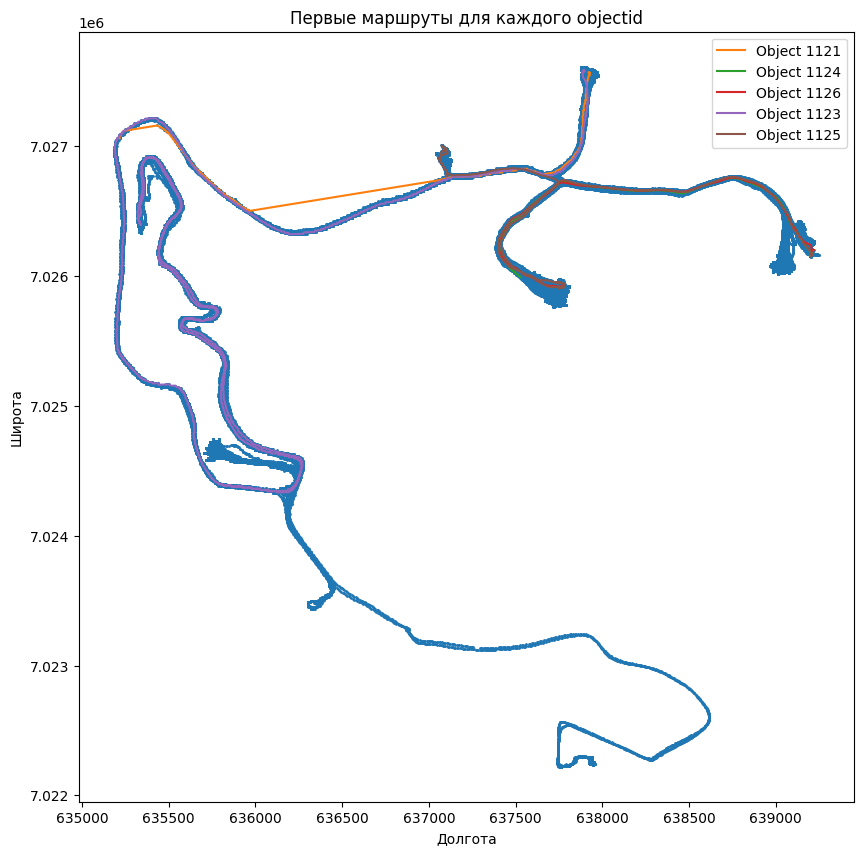

In [ ]:
# Получение списка уникальных objectid
objectids = df['objectid'].unique()

# Создание цветовой карты, исключая синий цвет
colors = plt.get_cmap('tab10').colors
colors = [color for i, color in enumerate(colors) if i != 0]  # исключаем синий цвет

plt.figure(figsize=(10, 10))

# Построение карты
plt.scatter(df['x'], df['y'], s=1)

# Построение маршрута для первого tripid каждого objectid
for i, objectid in enumerate(objectids):
    # Выбор первого tripid для текущего objectid
    first_tripid = df[df['objectid'] == objectid]['tripid'].min()

    # Фильтрация данных для текущего objectid и tripid
    df_temp = df[(df['objectid'] == objectid) & (df['tripid'] == first_tripid)]

    # Построение маршрута
    plt.plot(df_temp['x'], df_temp['y'], color=colors[i % len(colors)], label=f'Object {objectid}')

plt.title('Первые маршруты для каждого objectid')
plt.xlabel('Долгота')
plt.ylabel('Широта')
plt.legend()
plt.show()

In [ ]:
wth.sort_values(by = 'time', ascending = True).head(20)

,time,precipIntensity,precipProbability,temperature,apparentTemperature,dewPoint,humidity,pressure,windSpeed,windGust,windBearing,cloudCover,visibility,precipType,rain,snow,no_weather_info
4,2023-11-07 11:00:00+00:00,0.0,0.0,-10.27,-16.63,-14.37,69.0,1033.0,3.72,9.60,64.0,65.0,10000.0,clouds,0,0,1
20,2023-11-07 12:00:00+00:00,0.0,0.0,-10.27,-16.47,-14.53,68.0,1033.0,3.57,10.01,66.0,64.0,10000.0,clouds,0,0,1
19,2023-11-07 13:00:00+00:00,0.0,0.0,-11.27,-17.58,-15.50,68.0,1032.0,3.47,9.72,63.0,76.0,10000.0,clouds,0,0,1
5,2023-11-07 14:00:00+00:00,0.0,0.0,-12.27,-18.56,-16.63,67.0,1032.0,3.26,9.11,66.0,88.0,10000.0,clouds,0,0,1
14,2023-11-07 15:00:00+00:00,0.0,0.0,-12.27,-18.18,-16.63,67.0,1031.0,2.95,7.91,64.0,92.0,10000.0,clouds,0,0,1
3,2023-11-07 16:00:00+00:00,0.0,0.0,-13.27,-19.67,-17.44,68.0,1030.0,3.18,7.71,61.0,94.0,10000.0,clouds,0,0,1
34,2023-11-07 17:00:00+00:00,0.0,0.0,-13.27,-20.04,-17.28,69.0,1029.0,3.49,8.22,59.0,95.0,10000.0,clouds,0,0,1
2,2023-11-07 18:00:00+00:00,0.0,0.0,-13.27,-20.10,-17.59,67.0,1028.0,3.55,8.92,62.0,95.0,10000.0,clouds,0,0,1
54,2023-11-07 19:00:00+00:00,0.0,0.0,-14.27,-21.15,-18.56,67.0,1028.0,3.40,8.11,61.0,100.0,10000.0,clouds,0,0,1
0,2023-11-07 20:00:00+00:00,0.0,0.0,-13.27,-20.02,-17.59,67.0,1027.0,3.48,8.91,60.0,100.0,10000.0,clouds,0,0,1


In [ ]:
wth.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 55 entries, 0 to 54
Data columns (total 17 columns):
 #   Column               Non-Null Count  Dtype              
---  ------               --------------  -----              
 0   time                 55 non-null     datetime64[ns, UTC]
 1   precipIntensity      55 non-null     float64            
 2   precipProbability    55 non-null     float64            
 3   temperature          55 non-null     float64            
 4   apparentTemperature  55 non-null     float64            
 5   dewPoint             55 non-null     float64            
 6   humidity             55 non-null     float64            
 7   pressure             55 non-null     float64            
 8   windSpeed            55 non-null     float64            
 9   windGust             55 non-null     float64            
 10  windBearing          55 non-null     float64            
 11  cloudCover           55 non-null     float64            
 12  visibility           55 

In [ ]:

# Округление 'time' до ближайшего часа

tel['new_time'] = tel['time'].dt.round('H')
wth['new_time'] = wth['time'].dt.round('H')

# Присоединение датафреймов
merged_df = pd.merge(tel, wth, on='new_time', how='left')
merged_df


<ipython-input-26-53d64fd76352>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tel['new_time'] = tel['time'].dt.round('H')


,objectid,time_x,lat,lon,speed,height,fuel_cons,engine_speed,hdop,DQ_vertical_bump,...,pressure,windSpeed,windGust,windBearing,cloudCover,visibility,precipType,rain,snow,no_weather_info
0,1121,2023-11-08 00:00:00.803000+07:00,63.346624,83.702188,19.4590,132.0,390.00,NaN,4.91,0,...,1029.0,3.49,8.22,59.0,95.0,10000.0,clouds,0,0,1
1,1121,2023-11-08 00:00:01.805000+07:00,63.346724,83.702188,19.9201,132.2,383.00,NaN,4.92,0,...,1029.0,3.49,8.22,59.0,95.0,10000.0,clouds,0,0,1
2,1121,2023-11-08 00:00:02.806000+07:00,63.346824,83.702288,21.2628,132.5,385.00,NaN,4.84,0,...,1029.0,3.49,8.22,59.0,95.0,10000.0,clouds,0,0,1
3,1121,2023-11-08 00:00:03.807000+07:00,63.346824,83.702388,21.6202,132.8,389.00,NaN,4.83,0,...,1029.0,3.49,8.22,59.0,95.0,10000.0,clouds,0,0,1
4,1121,2023-11-08 00:00:04.808000+07:00,63.346924,83.702388,21.3536,133.0,389.00,NaN,8.56,0,...,1029.0,3.49,8.22,59.0,95.0,10000.0,clouds,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
340837,1126,2023-11-08 23:59:56+07:00,63.342244,83.755658,39.4000,274.0,5.10,686.0,6.00,0,...,1018.0,2.30,7.11,119.0,100.0,10000.0,snow,0,1,1
340838,1126,2023-11-08 23:59:57+07:00,63.342224,83.755998,38.3000,273.0,22.90,683.0,6.00,0,...,1018.0,2.30,7.11,119.0,100.0,10000.0,snow,0,1,1
340839,1126,2023-11-08 23:59:58+07:00,63.342224,83.755998,38.3000,273.0,21.20,699.0,6.00,0,...,1018.0,2.30,7.11,119.0,100.0,10000.0,snow,0,1,1
340840,1126,2023-11-08 23:59:59+07:00,63.342207,83.756331,37.9000,273.0,16.70,703.0,6.00,0,...,1018.0,2.30,7.11,119.0,100.0,10000.0,snow,0,1,1
